<a href="https://colab.research.google.com/github/takashi4488/rabbit_challenge/blob/main/2_1_vanishing_gradient_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Google Colab 用の処理

下記を実行します
- ドライブのマウント
- ノートブックファイルと同じフォルダへの移動

Googleドライブのマイドライブ を基準に DNN_code/DNN_code_colab_day2 フォルダを置くことを仮定しています。必要に応じて，パスを変更してください．

In [7]:
# Google Colab での実行かを調べる
import sys
import os
ENV_COLAB = True  if 'google.colab' in sys.modules else False

# google drive のマウント
if ENV_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ML-E検定/DNN_code_colab_day2_ver2/DNN_code_colab_day2/notebook')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import sys
ENV_COLAB = True if 'google.colab' in sys.modules else False

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

# MNISTデータの読み込み（Keras使用）


In [11]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

def load_mnist_data(normalize=True, one_hot_label=True):
    (x_train, d_train), (x_test, d_test) = mnist.load_data()

    # 形状を (N, 784) に変換
    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)

    if normalize:
        x_train = x_train.astype('float32') / 255.0
        x_test = x_test.astype('float32') / 255.0

    if one_hot_label:
        d_train = to_categorical(d_train, 10)
        d_test = to_categorical(d_test, 10)

    return (x_train, d_train), (x_test, d_test)

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist_data(normalize=True, one_hot_label=True)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# 活性化関数・レイヤークラス


In [12]:

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    if t.size == y.size:
        t = t.argmax(axis=1)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        return dout


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        self.out = out
        return out

    def backward(self, dout):
        return dout * (1.0 - self.out) * self.out


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.original_x_shape = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(*self.original_x_shape)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size:
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        return dx


# 動作確認

In [15]:

print(f"x_train: {x_train.shape}, d_train: {d_train.shape}")
print(f"x_test: {x_test.shape}, d_test: {d_test.shape}")

# ネットワークのテスト
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 50], output_size=10)
print(f"初期精度: {network.accuracy(x_test[:1000], d_test[:1000]):.4f}")

x_train: (60000, 784), d_train: (60000, 10)
x_test: (10000, 784), d_test: (10000, 10)
初期精度: 0.0990


#sigmoid - gauss
###活性化関数：シグモイド
###重みの初期値：ガウス分布から生成

Generation: 10. 正答率(トレーニング) = 0.1300, 正答率(テスト) = 0.1028
Generation: 20. 正答率(トレーニング) = 0.1500, 正答率(テスト) = 0.1135
Generation: 30. 正答率(トレーニング) = 0.1000, 正答率(テスト) = 0.1135
Generation: 40. 正答率(トレーニング) = 0.1200, 正答率(テスト) = 0.1135
Generation: 50. 正答率(トレーニング) = 0.1100, 正答率(テスト) = 0.1028
Generation: 60. 正答率(トレーニング) = 0.1400, 正答率(テスト) = 0.1135
Generation: 70. 正答率(トレーニング) = 0.0900, 正答率(テスト) = 0.1135
Generation: 80. 正答率(トレーニング) = 0.1800, 正答率(テスト) = 0.1135
Generation: 90. 正答率(トレーニング) = 0.1000, 正答率(テスト) = 0.1135
Generation: 100. 正答率(トレーニング) = 0.1600, 正答率(テスト) = 0.1135
Generation: 110. 正答率(トレーニング) = 0.1700, 正答率(テスト) = 0.1135
Generation: 120. 正答率(トレーニング) = 0.0700, 正答率(テスト) = 0.1135
Generation: 130. 正答率(トレーニング) = 0.1400, 正答率(テスト) = 0.1135
Generation: 140. 正答率(トレーニング) = 0.1900, 正答率(テスト) = 0.1028
Generation: 150. 正答率(トレーニング) = 0.1100, 正答率(テスト) = 0.1135
Generation: 160. 正答率(トレーニング) = 0.1100, 正答率(テスト) = 0.1028
Generation: 170. 正答率(トレーニング) = 0.1400, 正答率(テスト) = 0.1028
Generation: 180. 正答率(トレーニング) = 0.1100, 正

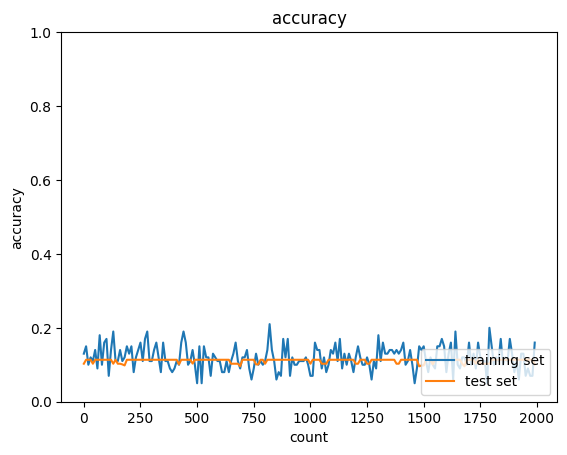

In [17]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新（層数に依存しない）
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

        print(f'Generation: {i+1}. 正答率(トレーニング) = {accr_train:.4f}, 正答率(テスト) = {accr_test:.4f}')

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

#隠れ層のサイズを変えてみる
###[40, 20] → [20, 10]に変更

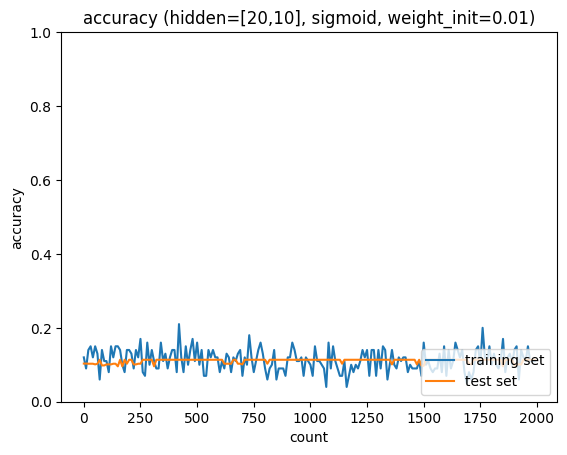

最終精度 - トレーニング: 0.1100, テスト: 0.1135


In [18]:
network = MultiLayerNet(input_size=784, hidden_size_list=[20, 10], output_size=10, activation='sigmoid', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新（層数に依存しない）
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[20,10], sigmoid, weight_init=0.01)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

###結果変わらず

#ReLU - gauss
###活性化関数：ReLU
###重みの初期値：ガウス分布から生成

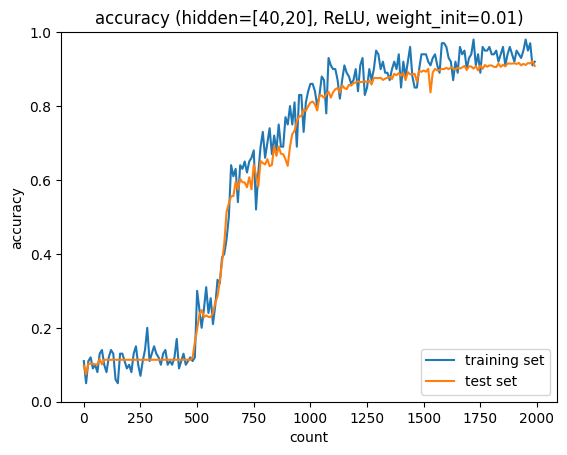

最終精度 - トレーニング: 0.9200, テスト: 0.9085


In [19]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std=0.01)

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], ReLU, weight_init=0.01)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

#sigmoid - Xavier

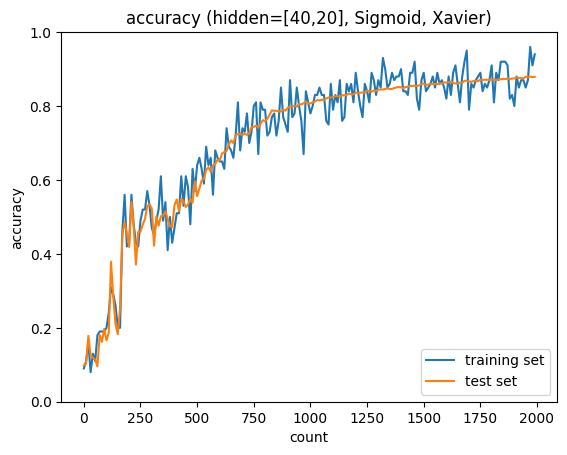

最終精度 - トレーニング: 0.9400, テスト: 0.8791


In [20]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='sigmoid', weight_init_std='Xavier')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], Sigmoid, Xavier)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

#ReLU - He
###活性化関数：ReLU
###重みの初期値：Heの初期値を使用

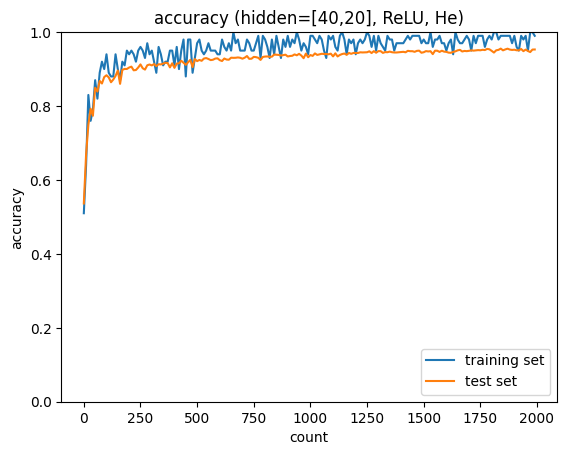

最終精度 - トレーニング: 0.9900, テスト: 0.9530


In [21]:
network = MultiLayerNet(input_size=784, hidden_size_list=[40, 20], output_size=10, activation='relu', weight_init_std='He')

iters_num = 2000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]

    # 勾配
    grad = network.gradient(x_batch, d_batch)

    # 全ての重みとバイアスを更新
    for idx in range(1, network.hidden_layer_num + 2):
        key_W = 'W' + str(idx)
        key_b = 'b' + str(idx)
        network.params[key_W] -= learning_rate * grad[key_W]
        network.params[key_b] -= learning_rate * grad[key_b]

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i + 1) % plot_interval == 0:
        accr_test = network.accuracy(x_test, d_test)
        accuracies_test.append(accr_test)
        accr_train = network.accuracy(x_batch, d_batch)
        accuracies_train.append(accr_train)

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test, label="test set")
plt.legend(loc="lower right")
plt.title("accuracy (hidden=[40,20], ReLU, He)")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.show()

# 最終結果
print(f"最終精度 - トレーニング: {accuracies_train[-1]:.4f}, テスト: {accuracies_test[-1]:.4f}")

###改善が見られた